In [121]:
import pandas as pd  # requires: pip install pandas
import torch
from chronos import BaseChronosPipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
from sklearn.linear_model import SGDRegressor
import time
from sklearn.preprocessing import  StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error
from alpha_vantage.timeseries import TimeSeries
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_diabetes


# from alpha_vantage.timeseries import TimeSeries

# ts = TimeSeries(key='AAPL', output_format='pandas')
# data, meta_data = ts.get_intraday(symbol='MSFT',interval='60min', outputsize='full')


# print(data)

In [122]:
#data.to_csv('data.csv')

data = pd.read_csv('data.csv')
print(data)

                    date   1. open   2. high    3. low  4. close   5. volume
0    2024-12-11 19:00:00  448.7900  448.8000  448.0000  448.2000     10402.0
1    2024-12-11 18:00:00  448.7700  448.9900  448.5000  448.6500     83719.0
2    2024-12-11 17:00:00  448.9900  475.6000  417.1400  448.7700   1500160.0
3    2024-12-11 16:00:00  448.9900  449.3300  417.9650  448.9200  10715980.0
4    2024-12-11 15:00:00  448.4200  449.7200  448.4078  449.0000   1999257.0
..                   ...       ...       ...       ...       ...         ...
328  2024-11-12 08:00:00  417.1614  417.9598  415.6840  417.4558     90347.0
329  2024-11-12 07:00:00  417.3310  417.3710  416.5726  416.6923     36379.0
330  2024-11-12 06:00:00  416.6524  417.3310  416.1634  417.3310     17394.0
331  2024-11-12 05:00:00  416.2332  417.1614  415.9837  416.7622     25976.0
332  2024-11-12 04:00:00  416.5825  417.1614  415.7542  416.2332     19162.0

[333 rows x 6 columns]


In [123]:


pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",  # use "amazon/chronos-bolt-small" for the corresponding Chronos-Bolt model
    device_map="cpu",  # use "cpu" for CPU inference
    torch_dtype=torch.bfloat16,
)

# df = pd.read_csv(
#     "https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv"
# )

#print(df)
df = data.loc[:, ['4. close']]
scale = StandardScaler()
df = scale.fit_transform(df)

man = 250 
X_train = df[0:man]
cool = df.shape[0] - man

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# quantiles is an fp32 tensor with shape [batch_size, prediction_length, num_quantile_levels]
# mean is an fp32 tensor with shape [batch_size, prediction_length]
quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(X_train),
    prediction_length=cool,
    quantile_levels=[0.1, 0.5, 0.9],
)

We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


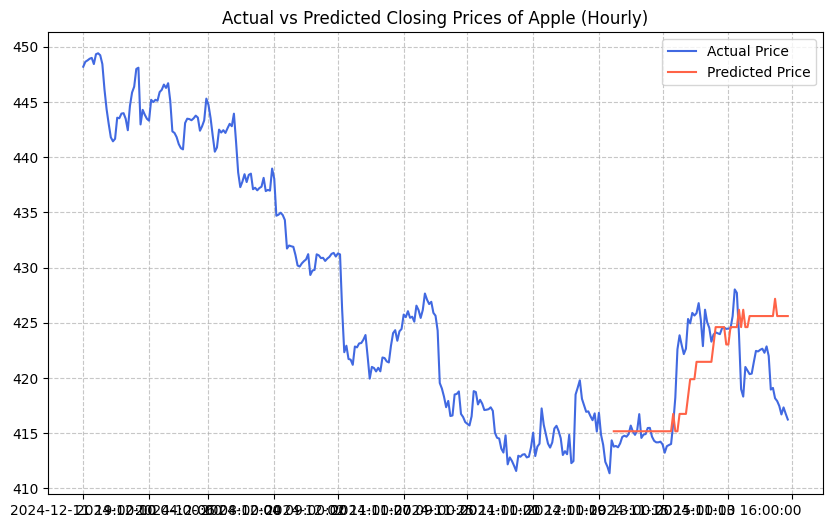

In [142]:
import matplotlib.pyplot as plt  # requires: pip install matplotlib
import matplotlib.dates as mdates
ytrue = df.loc[man:man+cool,['4. close']].to_numpy()

forecast_index = range(len(X_train), len(X_train) + cool)
low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]
median = median.numpy()
median = (median*ytrue.std()) + ytrue.mean()
fig = plt.figure(figsize=(10, 6))
plt.plot(df['date'],df["4. close"], color="royalblue", label="Actual Price")
plt.plot(forecast_index, median, color="tomato", label="Predicted Price")
#plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(1))
plt.grid(axis='x', linestyle='--', alpha=0.7,)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title("Actual vs Predicted Closing Prices of Apple (Hourly)")
plt.show()

In [139]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error

ytrue = df.loc[man:man+cool,['4. close']].to_numpy()
print(ytrue.shape)

print(root_mean_squared_error(median,df.loc[man:man+cool,['4. close']]))
print(mean_absolute_error(median,df.loc[man:man+cool,['4. close']]))

count = 0
for i in range(1,cool):
    if np.sign(median[i].numpy() - median[i-1].numpy()) == np.sign(ytrue[i] - ytrue[i-1]):
        count+=1

print(count / cool)

(83, 1)
4.115932105124777
3.0973154449830558
0.13253012048192772
